In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf 
import pandas_datareader as pdr
from simulation.simulation import simulate_normal_returns, alpha_stable_sampler_QMC

%load_ext autoreload
%autoreload 2

In [2]:
# TO DO : i) entrainer le LSTM ii) calculer les poids optimaux et ploter

## 1) Loading market data 

In [3]:
tickers_cac40 = [
    "ACC.PA",  # Accor
    "AI.PA",   # Air Liquide
    "AIR.PA",  # Airbus Group
    "MT.AS",   # ArcelorMittal
    "CS.PA",   # AXA
    "BNP.PA",  # BNP Paribas
    "EN.PA",   # Bouygues
    "CAP.PA",  # Capgemini
    "CA.PA",   # Carrefour
    "ACA.PA",  # Crédit Agricole
    "BN.PA",   # Danone
    "DSY.PA",  # Dassault Systèmes
    "EDEN.PA", # Edenred
    "ENGI.PA", # Engie
    "EL.PA",   # EssilorLuxottica
    "ERF.PA",  # Eurofins Scientific
    "RMS.PA",  # Hermès International
    "KER.PA",  # Kering
    "LR.PA",   # Legrand
    "OR.PA",   # L'Oréal
    "MC.PA",   # LVMH
    "ML.PA",   # Michelin
    "ORA.PA",  # Orange
    "RI.PA",   # Pernod Ricard
    "PUB.PA",  # Publicis Groupe
    "RNO.PA",  # Renault
    "SAF.PA",  # Safran
    "SGO.PA",  # Saint-Gobain
    "SAN.PA",  # Sanofi
    "SU.PA",   # Schneider Electric
    "GLE.PA",  # Société Générale
    "STLA.PA", # Stellantis
    "STM.PA",  # STMicroelectronics
    "TEP.PA",  # Téléperformance
    "HO.PA",   # Thales
    "TTE.PA",  # TotalEnergies
    "URW.PA",  # Unibail-Rodamco-Westfield
    "VIE.PA",  # Veolia Environnement
    "DG.PA",   # Vinci
    "VIV.PA"   # Vivendi
]

tickers_cac40_dict = {
    "ACC.PA": "Accor",
    "AI.PA": "Air Liquide",
    "AIR.PA": "Airbus Group",
    "MT.AS": "ArcelorMittal",
    "CS.PA": "AXA",
    "BNP.PA": "BNP Paribas",
    "EN.PA": "Bouygues",
    "CAP.PA": "Capgemini",
    "CA.PA": "Carrefour",
    "ACA.PA": "Crédit Agricole",
    "BN.PA": "Danone",
    "DSY.PA": "Dassault Systèmes",
    "EDEN.PA": "Edenred",
    "ENGI.PA": "Engie",
    "EL.PA": "EssilorLuxottica",
    "ERF.PA": "Eurofins Scientific",
    "RMS.PA": "Hermès International",
    "KER.PA": "Kering",
    "LR.PA": "Legrand",
    "OR.PA": "L'Oréal",
    "MC.PA": "LVMH",
    "ML.PA": "Michelin",
    "ORA.PA": "Orange",
    "RI.PA": "Pernod Ricard",
    "PUB.PA": "Publicis Groupe",
    "RNO.PA": "Renault",
    "SAF.PA": "Safran",
    "SGO.PA": "Saint-Gobain",
    "SAN.PA": "Sanofi",
    "SU.PA": "Schneider Electric",
    "GLE.PA": "Société Générale",
    "STLA.PA": "Stellantis",
    "STM.PA": "STMicroelectronics",
    "TEP.PA": "Téléperformance",
    "HO.PA": "Thales",
    "TTE.PA": "TotalEnergies",
    "URW.PA": "Unibail-Rodamco-Westfield",
    "VIE.PA": "Veolia Environnement",
    "DG.PA": "Vinci",
    "VIV.PA": "Vivendi"
}

In [4]:
selected_tickers = [tickers_cac40[i] for i in [1,4,6,8]]
selected_tickers_names = [tickers_cac40_dict[key] for key in selected_tickers]
start_date = '2010-01-01'
interval = '1d'

market_data = yf.download(selected_tickers, start='2010-01-01', interval=interval)
market_data.index = market_data.index.tz_localize(None).floor('D')
# Pk utiliser la date comme ça sans jour?
#market_data["Date"] = market_data["Date"].dt.strftime('%Y/%m')
market_data = market_data[["Adj Close"]]
print(market_data.shape)
market_data.head()

[*********************100%***********************]  4 of 4 completed

(3827, 4)


Price       Adj Close                                
Ticker          AI.PA      CA.PA     CS.PA      EN.PA
Date                                                 
2010-01-04  30.840050  21.601980  7.704947  16.894001
2010-01-05  30.223249  22.113441  7.833363  17.101635
2010-01-06  30.037119  21.951422  7.913623  17.192905
2010-01-07  30.000614  21.703638  7.824189  16.957888
2010-01-08  30.095512  21.916477  7.849415  16.964733

## 2) Retrieving useful statistics

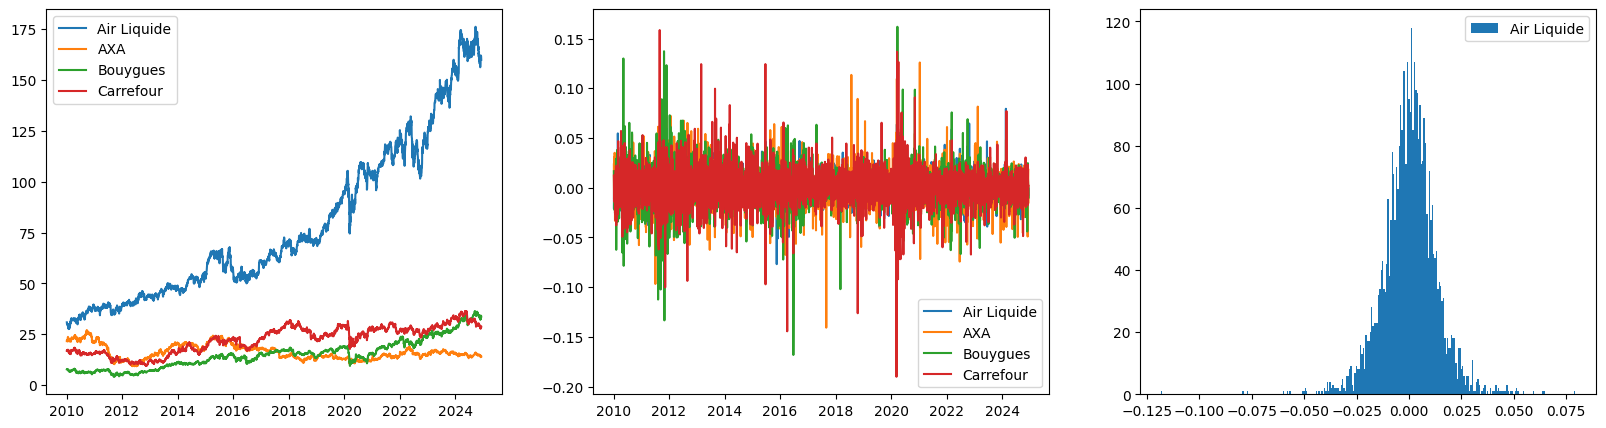

In [5]:
market_returns = np.log(market_data['Adj Close']) - np.log(market_data['Adj Close'].shift(1))
market_returns.dropna(inplace=True)
mean_returns = market_returns.mean()
mean_returns_value = mean_returns.values
cov_market = market_returns.cov() 
cov_market_values = cov_market.values

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(market_data['Adj Close'], label=selected_tickers_names)
plt.legend()
plt.subplot(132)
plt.plot(market_returns, label=selected_tickers_names)
plt.legend()
plt.subplot(133)
i = 0 
plt.hist(market_returns.iloc[:,i], label=selected_tickers_names[i], bins=300)
plt.legend()
plt.show()

In [6]:
market_returns

Ticker,AI.PA,CA.PA,CS.PA,EN.PA
Date,,,,
2010-01-05,-0.020203,0.023401,0.016529,0.012215
2010-01-06,-0.006178,-0.007354,0.010194,0.005323
2010-01-07,-0.001216,-0.011352,-0.011366,-0.013764
2010-01-08,0.003158,0.009759,0.003219,0.000404
2010-01-11,-0.006204,-0.015042,-0.005272,0.009771
...,...,...,...,...
2024-12-05,0.003098,0.001425,0.024670,0.022990
2024-12-06,0.002471,0.006739,0.010347,0.008703
2024-12-09,-0.002471,0.018908,0.002057,0.001039


### 3) Simulating returns

In [7]:
np.random.seed(42)

In [8]:
# N correspond au nombre de timesteps (on est dans l'unité de la data originale, donc jour en l'occurence cf variable "interval" plus haut)
# La 2e dimension du tenseur donne les différentes simulations 
# la 3e au nombre d'assets

#N = le nbre de timsteps
N = market_returns.shape[0]
simulated_returns = simulate_normal_returns(mu=mean_returns_value, cov=cov_market_values, N= N, n_simul=10)
simulated_returns.shape

(3826, 10, 4)

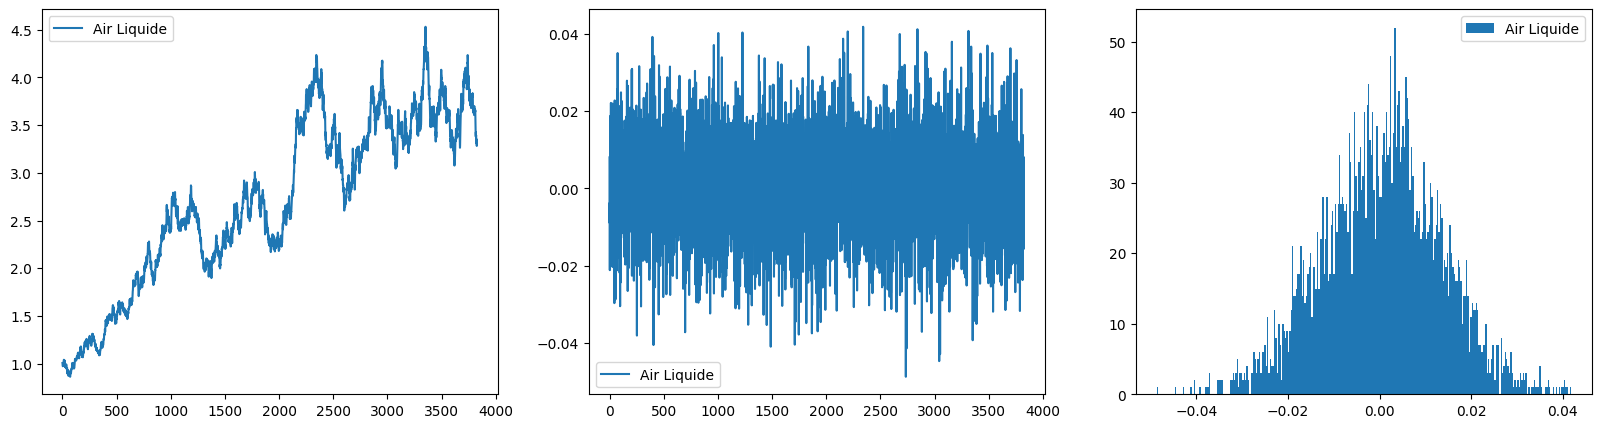

In [9]:
i = 0 
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(np.cumprod(1 + simulated_returns[:, i, 0]), label=selected_tickers_names[i])
plt.legend()
plt.subplot(132)
plt.plot(simulated_returns[:, i, 0], label=selected_tickers_names[i])
plt.legend()
plt.subplot(133)
i = 0 
plt.hist(simulated_returns[:, i, 0], label=selected_tickers_names[i], bins=300)
plt.legend()
plt.show()

## 3) Training the LSTM 

# Prblm : pk ça va pas jusqu'à la dernière date ?  fcts get training et test periods à modifier pour prendre toute la période peut etre

In [10]:
dates = market_data.index[:simulated_returns.shape[0]]  

single_simulation = simulated_returns[:, 0, :]

simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
simulation_df.index = dates[:len(simulation_df)]  

In [ ]:
from models.base import NN_Sharpe
import torch 

input_size=4
hidden_size=64  
output_size=4  
num_layers=1  
model_name='GRU'

model = NN_Sharpe(input_size, hidden_size, output_size, num_layers, model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.2)


In [12]:
from models.utils import training_with_model

num_simulations = simulated_returns.shape[1]  
dates = market_data.index[:simulated_returns.shape[0]]  

# Itérer sur chaque simulation
for i in range(num_simulations):
    # Extraire la simulation i
    single_simulation = simulated_returns[:, i, :]
    
    simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
    simulation_df.index = dates[:len(simulation_df)]  
    
    print(f"Training on simulation {i + 1}/{num_simulations}...")

    # Entraîner le modèle sur cette simulation
    simulation_result = training_with_model(
        data_used=simulation_df.dropna(),  
        model=model, 
        optimizer=optimizer, 
        initial_train_years=4,  
        retrain_years=2,  
        rolling_window=50, 
        shuffle=False,  
        epoch=50,
        batch_size=64,  
        overlap=False 
    )

    #taking the final results 
    if(i==num_simulations-1):
        results = simulation_result
    



Training on simulation 1/10...
training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([20, 50, 4])
epoch 0, loss = -0.05532030016183853
epoch 1, loss = -0.055327244102954865
epoch 2, loss = -0.0553341880440712
epoch 3, loss = -0.05534110590815544
epoch 4, loss = -0.055347990244627
epoch 5, loss = -0.05535483360290527
epoch 6, loss = -0.05536163970828056
epoch 7, loss = -0.05536841228604317


c:\Users\tahah\CMAP-Projet Finance\DL-Portfolio-CMAP\models\utils.py:104: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_8f7uhuge1i\croot\pytorch-select_1717607507421\work\torch\csrc\utils\tensor_new.cpp:277.)
  X_tensor = torch.tensor([df[0].values for df in data_training], dtype=torch.float32)


epoch 8, loss = -0.05537513643503189
epoch 9, loss = -0.05538180470466614
epoch 10, loss = -0.0553884282708168
epoch 11, loss = -0.0553949773311615
epoch 12, loss = -0.05540147423744202
epoch 13, loss = -0.05540791153907776
epoch 14, loss = -0.055414289236068726
epoch 15, loss = -0.05542060732841492
epoch 16, loss = -0.055426858365535736
epoch 17, loss = -0.055433083325624466
epoch 18, loss = -0.05543925613164902
epoch 19, loss = -0.05544538423418999
epoch 20, loss = -0.05545147508382797
epoch 21, loss = -0.05545753240585327
epoch 22, loss = -0.05546357110142708
epoch 23, loss = -0.0554695799946785
epoch 24, loss = -0.055475570261478424
epoch 25, loss = -0.05548154190182686
epoch 26, loss = -0.0554874949157238
epoch 27, loss = -0.05549342557787895
epoch 28, loss = -0.05549933761358261
epoch 29, loss = -0.055505238473415375
epoch 30, loss = -0.05551110953092575
epoch 31, loss = -0.05551695078611374
epoch 32, loss = -0.055522769689559937
epoch 33, loss = -0.055528558790683746
epoch 34, l

In [13]:
results = results.dropna(how='any')
results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.256716,0.244740,0.246928,0.251616,0.010390
2013-12-11,0.256716,0.244740,0.246928,0.251616,0.011447
2013-12-12,0.256716,0.244740,0.246928,0.251616,0.024890
2013-12-13,0.256716,0.244740,0.246928,0.251616,0.001942
2013-12-16,0.256716,0.244740,0.246928,0.251616,-0.004582
...,...,...,...,...,...
2023-10-05,0.257423,0.242565,0.248252,0.251760,-0.006397
2023-10-06,0.257423,0.242565,0.248252,0.251760,0.011556
2023-10-09,0.257423,0.242565,0.248252,0.251760,0.020595


In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np


paper_results = results.copy()

paper_results['cumulative_return'] = (1 + paper_results['return_pf']).cumprod()



In [15]:
paper_results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf,cumulative_return
Date,,,,,,
2013-12-10,0.256716,0.244740,0.246928,0.251616,0.010390,1.010390
2013-12-11,0.256716,0.244740,0.246928,0.251616,0.011447,1.021956
2013-12-12,0.256716,0.244740,0.246928,0.251616,0.024890,1.047393
2013-12-13,0.256716,0.244740,0.246928,0.251616,0.001942,1.049427
2013-12-16,0.256716,0.244740,0.246928,0.251616,-0.004582,1.044619
...,...,...,...,...,...,...
2023-10-05,0.257423,0.242565,0.248252,0.251760,-0.006397,1.385050
2023-10-06,0.257423,0.242565,0.248252,0.251760,0.011556,1.401055
2023-10-09,0.257423,0.242565,0.248252,0.251760,0.020595,1.429910


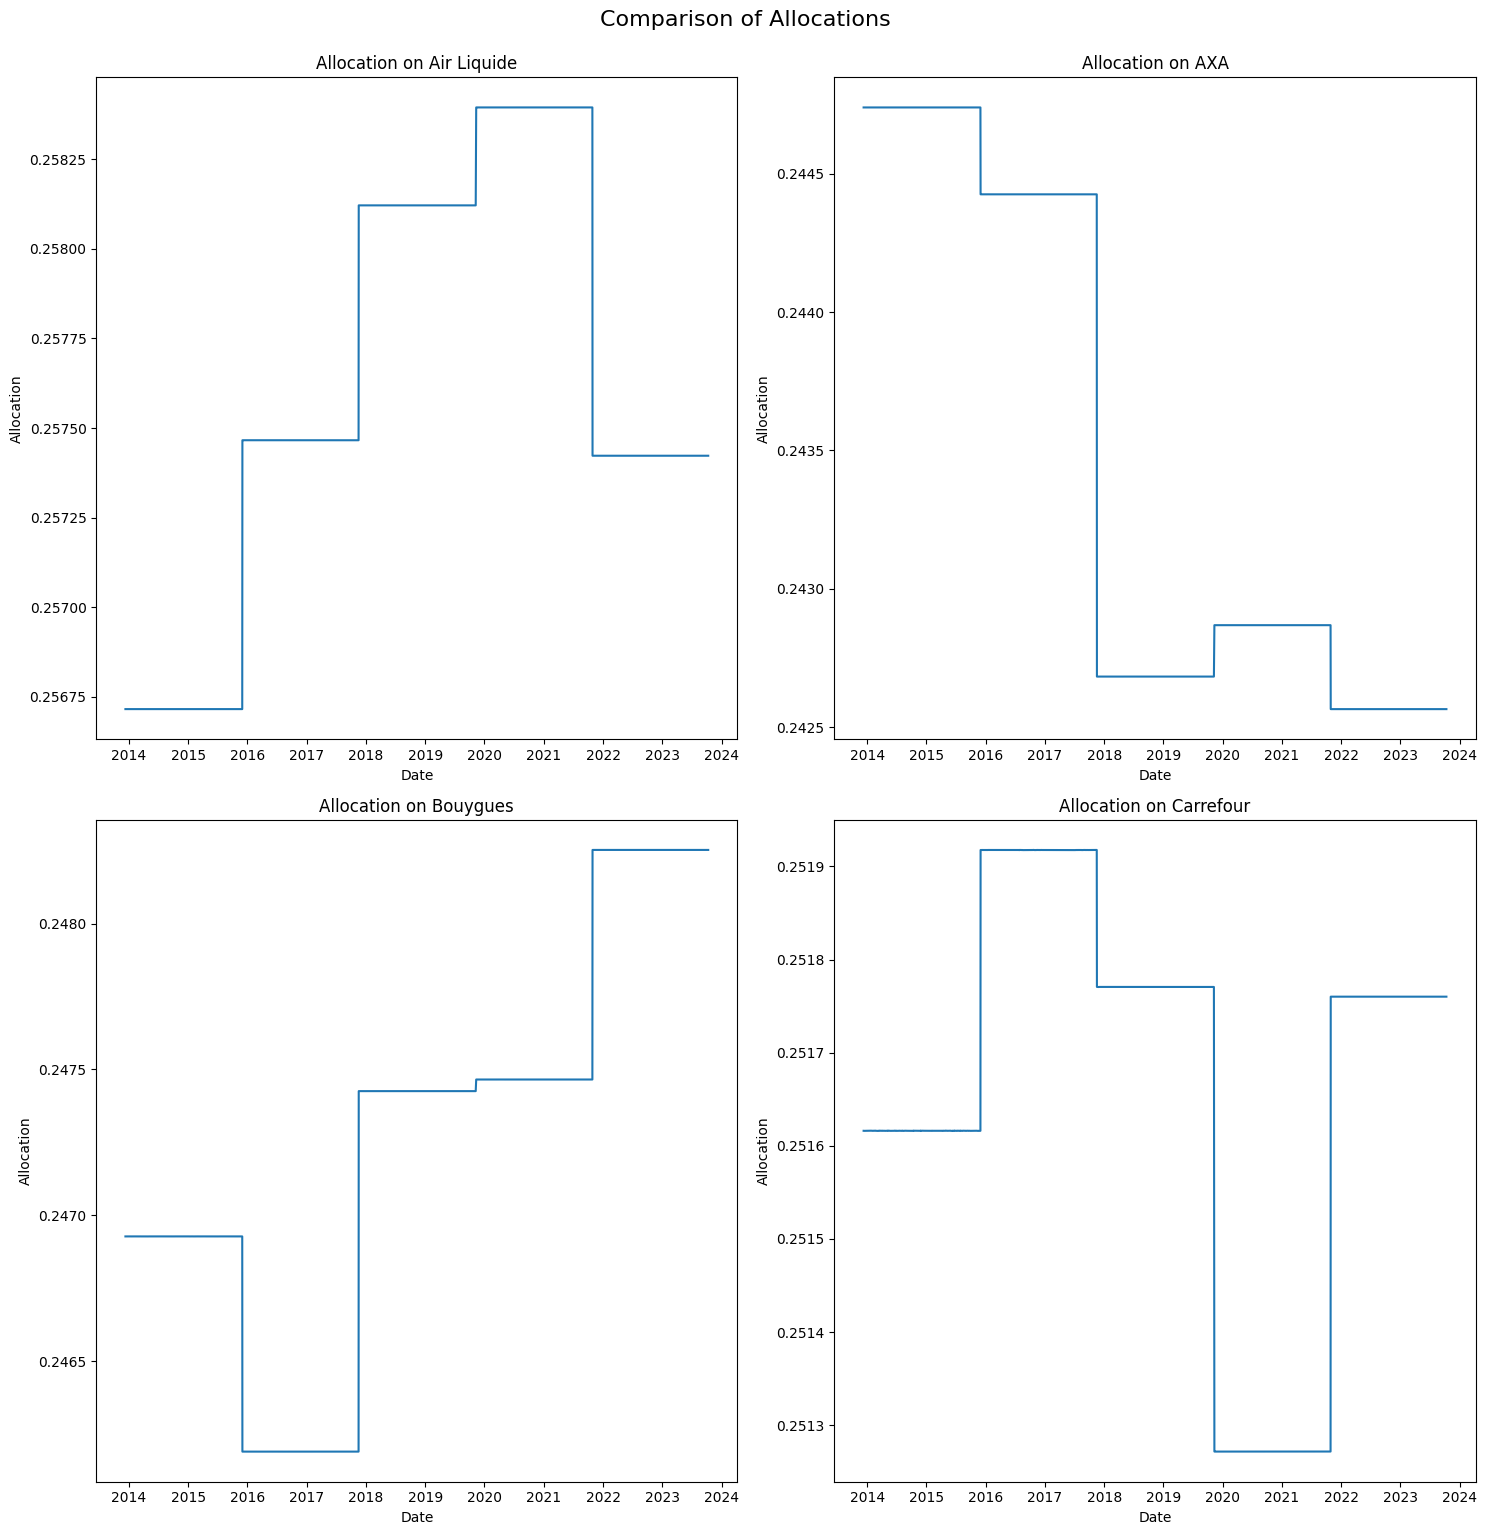

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axs = axs.flatten()

subplot_titles = [
    "Allocation on Air Liquide", "Allocation on AXA",
    "Allocation on Bouygues", "Allocation on Carrefour"
]

for i, ax in enumerate(axs):
    ax.set_title(subplot_titles[i])

# Allocation columns dictionary
allocations = {    
    'Air Liquide_alloc': 0,
    'AXA_alloc': 1,
    'Bouygues_alloc': 2,
    'Carrefour_alloc': 3
}

# Plot allocation for each asset
for alloc, ax_index in allocations.items():
    ax = axs[ax_index]
    if alloc in paper_results.columns:
        ax.plot(
            paper_results.index,
            paper_results[alloc],
            label=alloc,
        )
    ax.set_xlabel('Date')
    ax.set_ylabel('Allocation')

plt.tight_layout()
plt.suptitle("Comparison of Allocations", fontsize=16, y=1.02)
plt.show()

In [20]:
paper_results['cumulative_return']

Date
2013-12-10    1.010390
2013-12-11    1.021956
2013-12-12    1.047393
2013-12-13    1.049427
2013-12-16    1.044619
                ...   
2023-10-05    1.385050
2023-10-06    1.401055
2023-10-09    1.429910
2023-10-10    1.427515
2023-10-11    1.439338
Name: cumulative_return, Length: 2520, dtype: float64

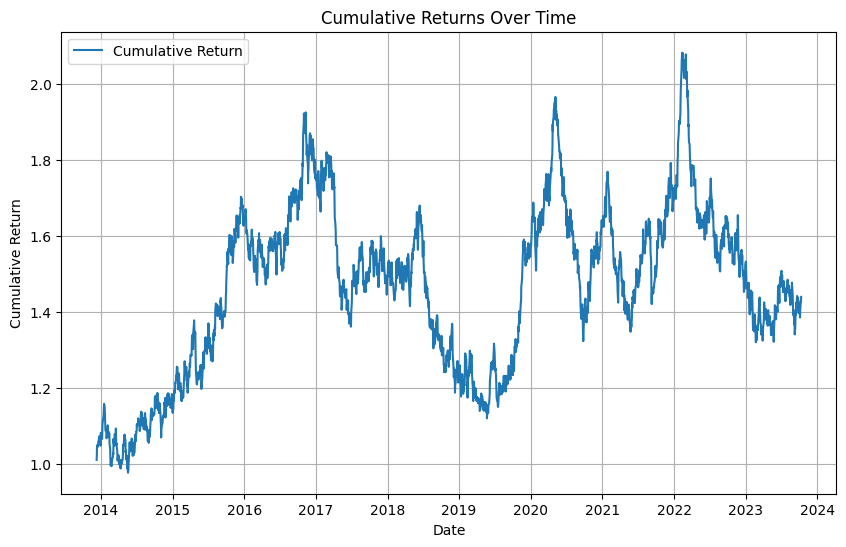

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(paper_results.index, paper_results['cumulative_return'], label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()


# GRU with Overlapping

In [22]:
from models.base import NN_Sharpe
import torch 

input_size=4
hidden_size=64  
output_size=4  
num_layers=1  
model_name='GRU'

model = NN_Sharpe(input_size, hidden_size, output_size, num_layers, model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.2)


In [23]:
from models.utils import training_with_model

num_simulations = simulated_returns.shape[1]  
dates = market_data.index[:simulated_returns.shape[0]]  

# Itérer sur chaque simulation
for i in range(num_simulations):
    # Extraire la simulation i
    single_simulation = simulated_returns[:, i, :]
    
    simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
    simulation_df.index = dates[:len(simulation_df)]  
    
    print(f"Training on simulation {i + 1}/{num_simulations}...")

    # Entraîner le modèle sur cette simulation
    simulation_result = training_with_model(
        data_used=simulation_df.dropna(),  
        model=model, 
        optimizer=optimizer, 
        initial_train_years=4,  
        retrain_years=2,  
        rolling_window=50, 
        shuffle=False,  
        epoch=50,
        batch_size=64,  
        overlap=True 
    )

    #taking the final results 
    if(i==num_simulations-1):
        results = simulation_result
    



Training on simulation 1/10...
training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([957, 50, 4])
epoch 0, loss = -0.059228057786822316
epoch 1, loss = -0.0593555361032486
epoch 2, loss = -0.059477073202530546
epoch 3, loss = -0.05959411760171254
epoch 4, loss = -0.0597065418958664
epoch 5, loss = -0.05981439476211866
epoch 6, loss = -0.0599177435040474
epoch 7, loss = -0.060016695658365884
epoch 8, loss = -0.0601113793750604
epoch 9, loss = -0.06020195186138153
epoch 10, loss = -0.060288575539986296
epoch 11, loss = -0.060371426244576774
epoch 12, loss = -0.06045065894722938
epoch 13, loss = -0.06052642837166786
epoch 14, loss = -0.060598909358183545
epoch 15, loss = -0.060668248186508816
epoch 16, loss = -0.06073460504412651
epoch 17, loss = -0.060798128694295885
epoch 18, loss = -0.06085895995299021
epoch 19, loss = -0.06091725255052249
epoch 20, loss = -0.060973129918177923
epoch 21, loss = -0.06102672393123309
e

In [24]:
results = results.dropna(how='any')
results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.257453,0.243763,0.246797,0.251987,0.010398
2013-12-11,0.257453,0.243763,0.246797,0.251987,0.011443
2013-12-12,0.257453,0.243763,0.246797,0.251987,0.024889
2013-12-13,0.257453,0.243763,0.246797,0.251987,0.001961
2013-12-16,0.257453,0.243763,0.246797,0.251987,-0.004562
...,...,...,...,...,...
2023-10-05,0.257573,0.238631,0.252908,0.250889,-0.006348
2023-10-06,0.257573,0.238631,0.252908,0.250889,0.011580
2023-10-09,0.257573,0.238631,0.252908,0.250889,0.020582


In [25]:
paper_results = results.copy()

paper_results['cumulative_return'] = (1 + paper_results['return_pf']).cumprod()



In [26]:
paper_results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf,cumulative_return
Date,,,,,,
2013-12-10,0.257453,0.243763,0.246797,0.251987,0.010398,1.010398
2013-12-11,0.257453,0.243763,0.246797,0.251987,0.011443,1.021961
2013-12-12,0.257453,0.243763,0.246797,0.251987,0.024889,1.047396
2013-12-13,0.257453,0.243763,0.246797,0.251987,0.001961,1.049450
2013-12-16,0.257453,0.243763,0.246797,0.251987,-0.004562,1.044663
...,...,...,...,...,...,...
2023-10-05,0.257573,0.238631,0.252908,0.250889,-0.006348,1.386142
2023-10-06,0.257573,0.238631,0.252908,0.250889,0.011580,1.402194
2023-10-09,0.257573,0.238631,0.252908,0.250889,0.020582,1.431054


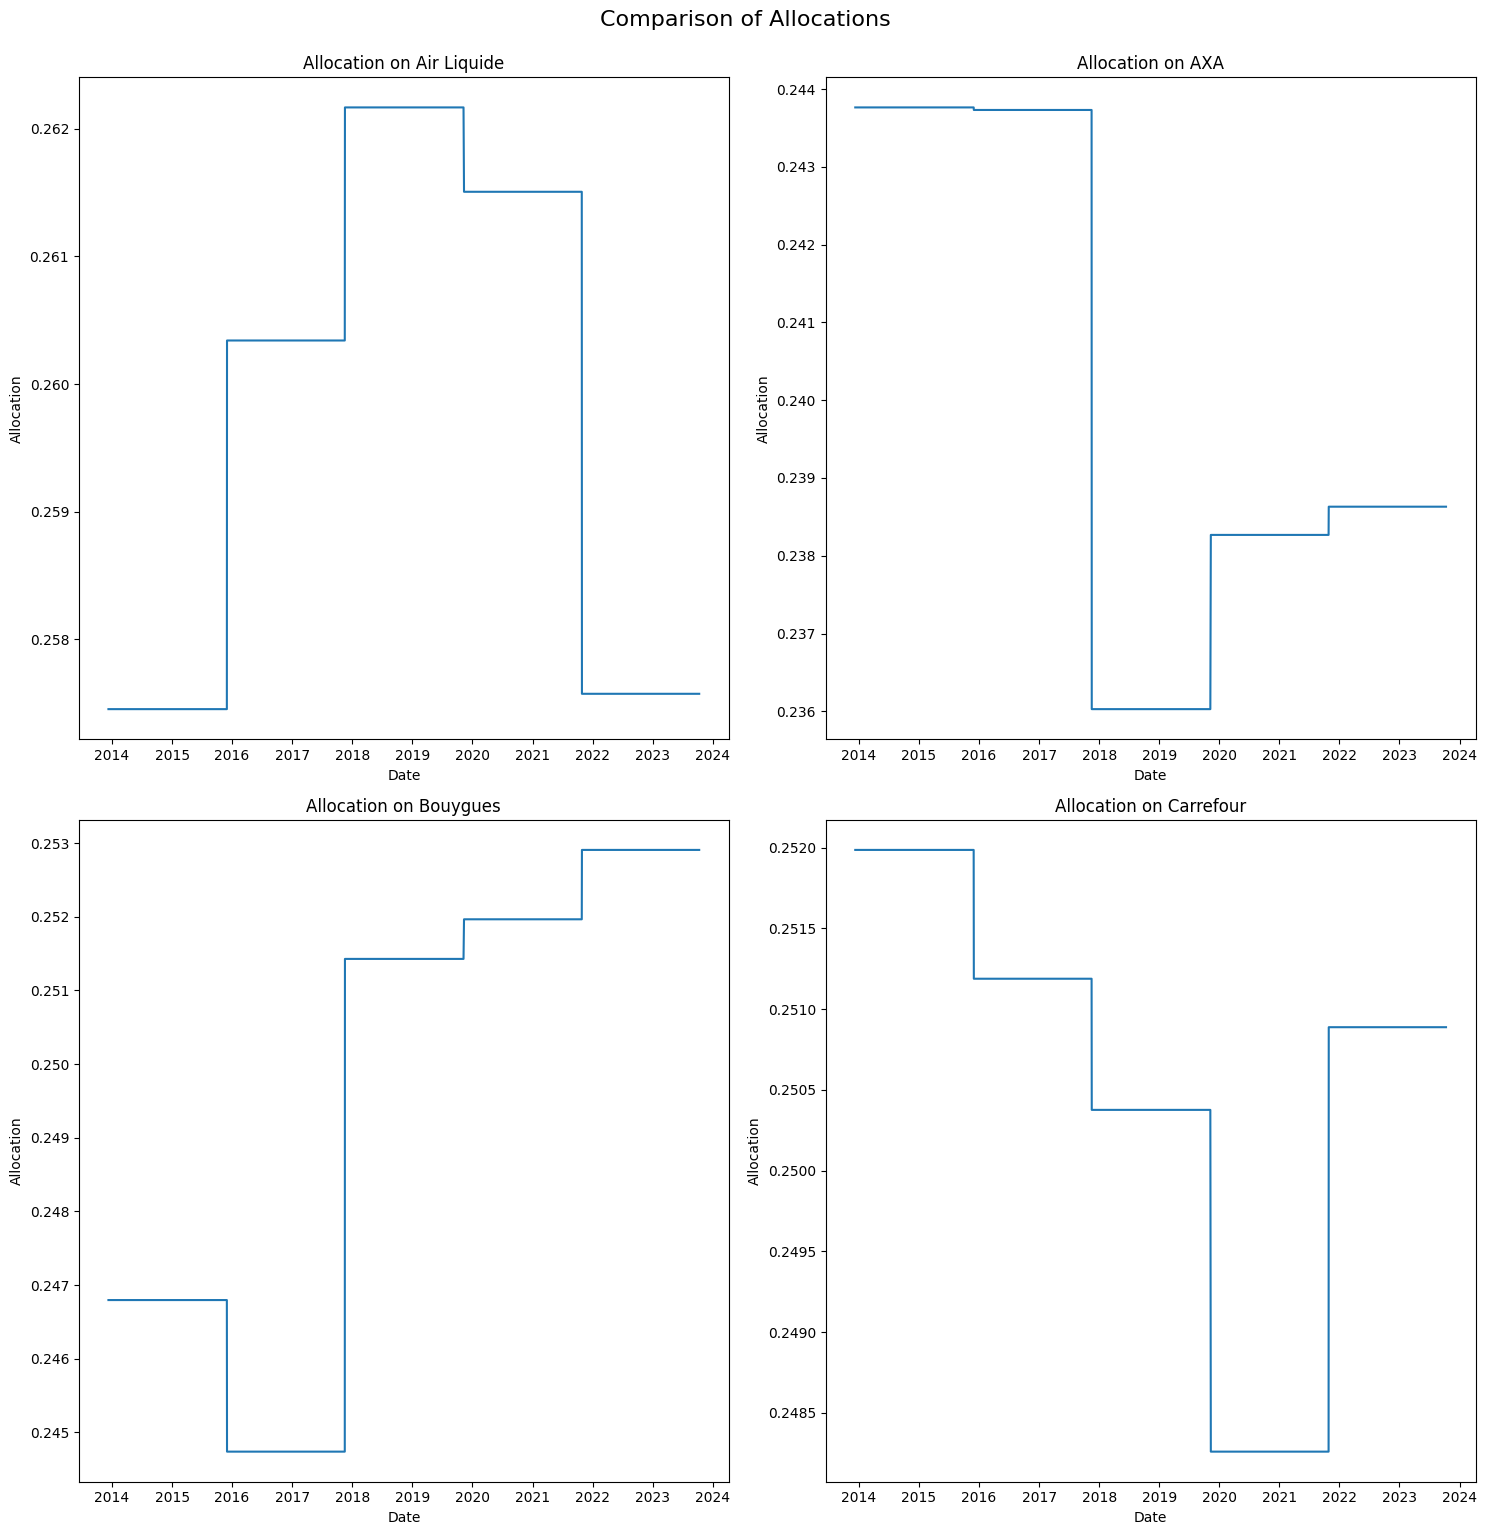

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axs = axs.flatten()

subplot_titles = [
    "Allocation on Air Liquide", "Allocation on AXA",
    "Allocation on Bouygues", "Allocation on Carrefour"
]

for i, ax in enumerate(axs):
    ax.set_title(subplot_titles[i])

# Allocation columns dictionary
allocations = {    
    'Air Liquide_alloc': 0,
    'AXA_alloc': 1,
    'Bouygues_alloc': 2,
    'Carrefour_alloc': 3
}

# Plot allocation for each asset
for alloc, ax_index in allocations.items():
    ax = axs[ax_index]
    if alloc in paper_results.columns:
        ax.plot(
            paper_results.index,
            paper_results[alloc],
            label=alloc,
        )
    ax.set_xlabel('Date')
    ax.set_ylabel('Allocation')

plt.tight_layout()
plt.suptitle("Comparison of Allocations", fontsize=16, y=1.02)
plt.show()

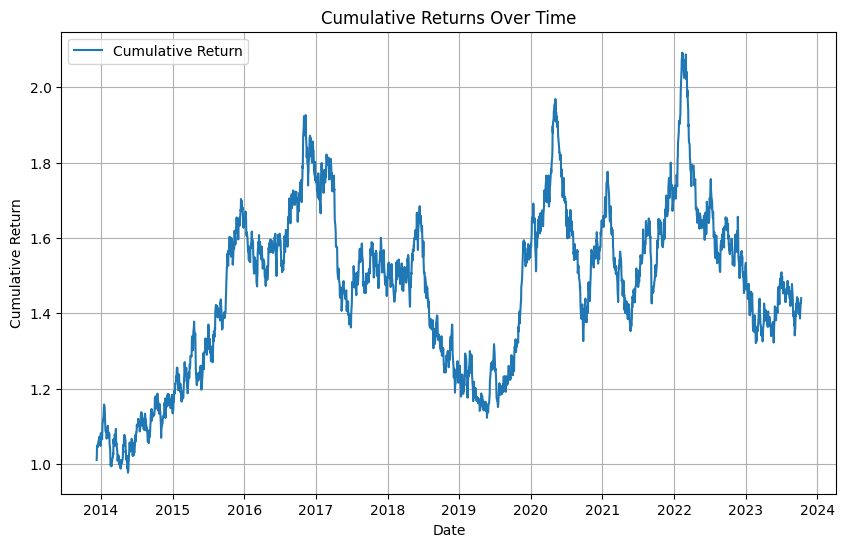

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(paper_results.index, paper_results['cumulative_return'], label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()


# LSTM Without Overlapping

In [29]:
input_size=4
hidden_size=64  
output_size=4  
num_layers=1  
model_name='LSTM'

model = NN_Sharpe(input_size, hidden_size, output_size, num_layers, model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.2)


In [30]:
num_simulations = simulated_returns.shape[1]  
dates = market_data.index[:simulated_returns.shape[0]]  

# Itérer sur chaque simulation
for i in range(num_simulations):
    # Extraire la simulation i
    single_simulation = simulated_returns[:, i, :]
    
    simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
    simulation_df.index = dates[:len(simulation_df)]  
    
    print(f"Training on simulation {i + 1}/{num_simulations}...")

    # Entraîner le modèle sur cette simulation
    simulation_result = training_with_model(
        data_used=simulation_df.dropna(),  
        model=model, 
        optimizer=optimizer, 
        initial_train_years=4,  
        retrain_years=2,  
        rolling_window=50, 
        shuffle=False,  
        epoch=50,
        batch_size=64,  
        overlap=False 
    )

    #taking the final results 
    if(i==num_simulations-1):
        results = simulation_result
    



Training on simulation 1/10...
training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([20, 50, 4])
epoch 0, loss = -0.06209979206323624
epoch 1, loss = -0.0620969757437706
epoch 2, loss = -0.06209417060017586
epoch 3, loss = -0.06209136173129082
epoch 4, loss = -0.062088530510663986
epoch 5, loss = -0.062085676938295364
epoch 6, loss = -0.06208278611302376
epoch 7, loss = -0.06207987666130066
epoch 8, loss = -0.062076933681964874
epoch 9, loss = -0.06207394599914551
epoch 10, loss = -0.06207093596458435
epoch 11, loss = -0.0620679147541523
epoch 12, loss = -0.06206486374139786
epoch 13, loss = -0.062061797827482224
epoch 14, loss = -0.06205872818827629
epoch 15, loss = -0.06205564737319946
epoch 16, loss = -0.06205255910754204
epoch 17, loss = -0.06204947084188461
epoch 18, loss = -0.06204637885093689
epoch 19, loss = -0.06204327195882797
epoch 20, loss = -0.062040187418460846
epoch 21, loss = -0.062037087976932526
epo

In [31]:
results = results.dropna(how='any')
results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.257344,0.244537,0.248287,0.249832,0.010395
2013-12-11,0.257344,0.244538,0.248287,0.249832,0.011420
2013-12-12,0.257344,0.244538,0.248287,0.249832,0.024882
2013-12-13,0.257344,0.244538,0.248287,0.249832,0.001916
2013-12-16,0.257344,0.244538,0.248287,0.249832,-0.004612
...,...,...,...,...,...
2023-10-05,0.257793,0.242644,0.249018,0.250545,-0.006439
2023-10-06,0.257793,0.242644,0.249018,0.250545,0.011558
2023-10-09,0.257793,0.242644,0.249018,0.250545,0.020612


In [32]:
paper_results = results.copy()

paper_results['cumulative_return'] = (1 + paper_results['return_pf']).cumprod()



In [33]:
paper_results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf,cumulative_return
Date,,,,,,
2013-12-10,0.257344,0.244537,0.248287,0.249832,0.010395,1.010395
2013-12-11,0.257344,0.244538,0.248287,0.249832,0.011420,1.021934
2013-12-12,0.257344,0.244538,0.248287,0.249832,0.024882,1.047362
2013-12-13,0.257344,0.244538,0.248287,0.249832,0.001916,1.049369
2013-12-16,0.257344,0.244538,0.248287,0.249832,-0.004612,1.044529
...,...,...,...,...,...,...
2023-10-05,0.257793,0.242644,0.249018,0.250545,-0.006439,1.385961
2023-10-06,0.257793,0.242644,0.249018,0.250545,0.011558,1.401979
2023-10-09,0.257793,0.242644,0.249018,0.250545,0.020612,1.430877


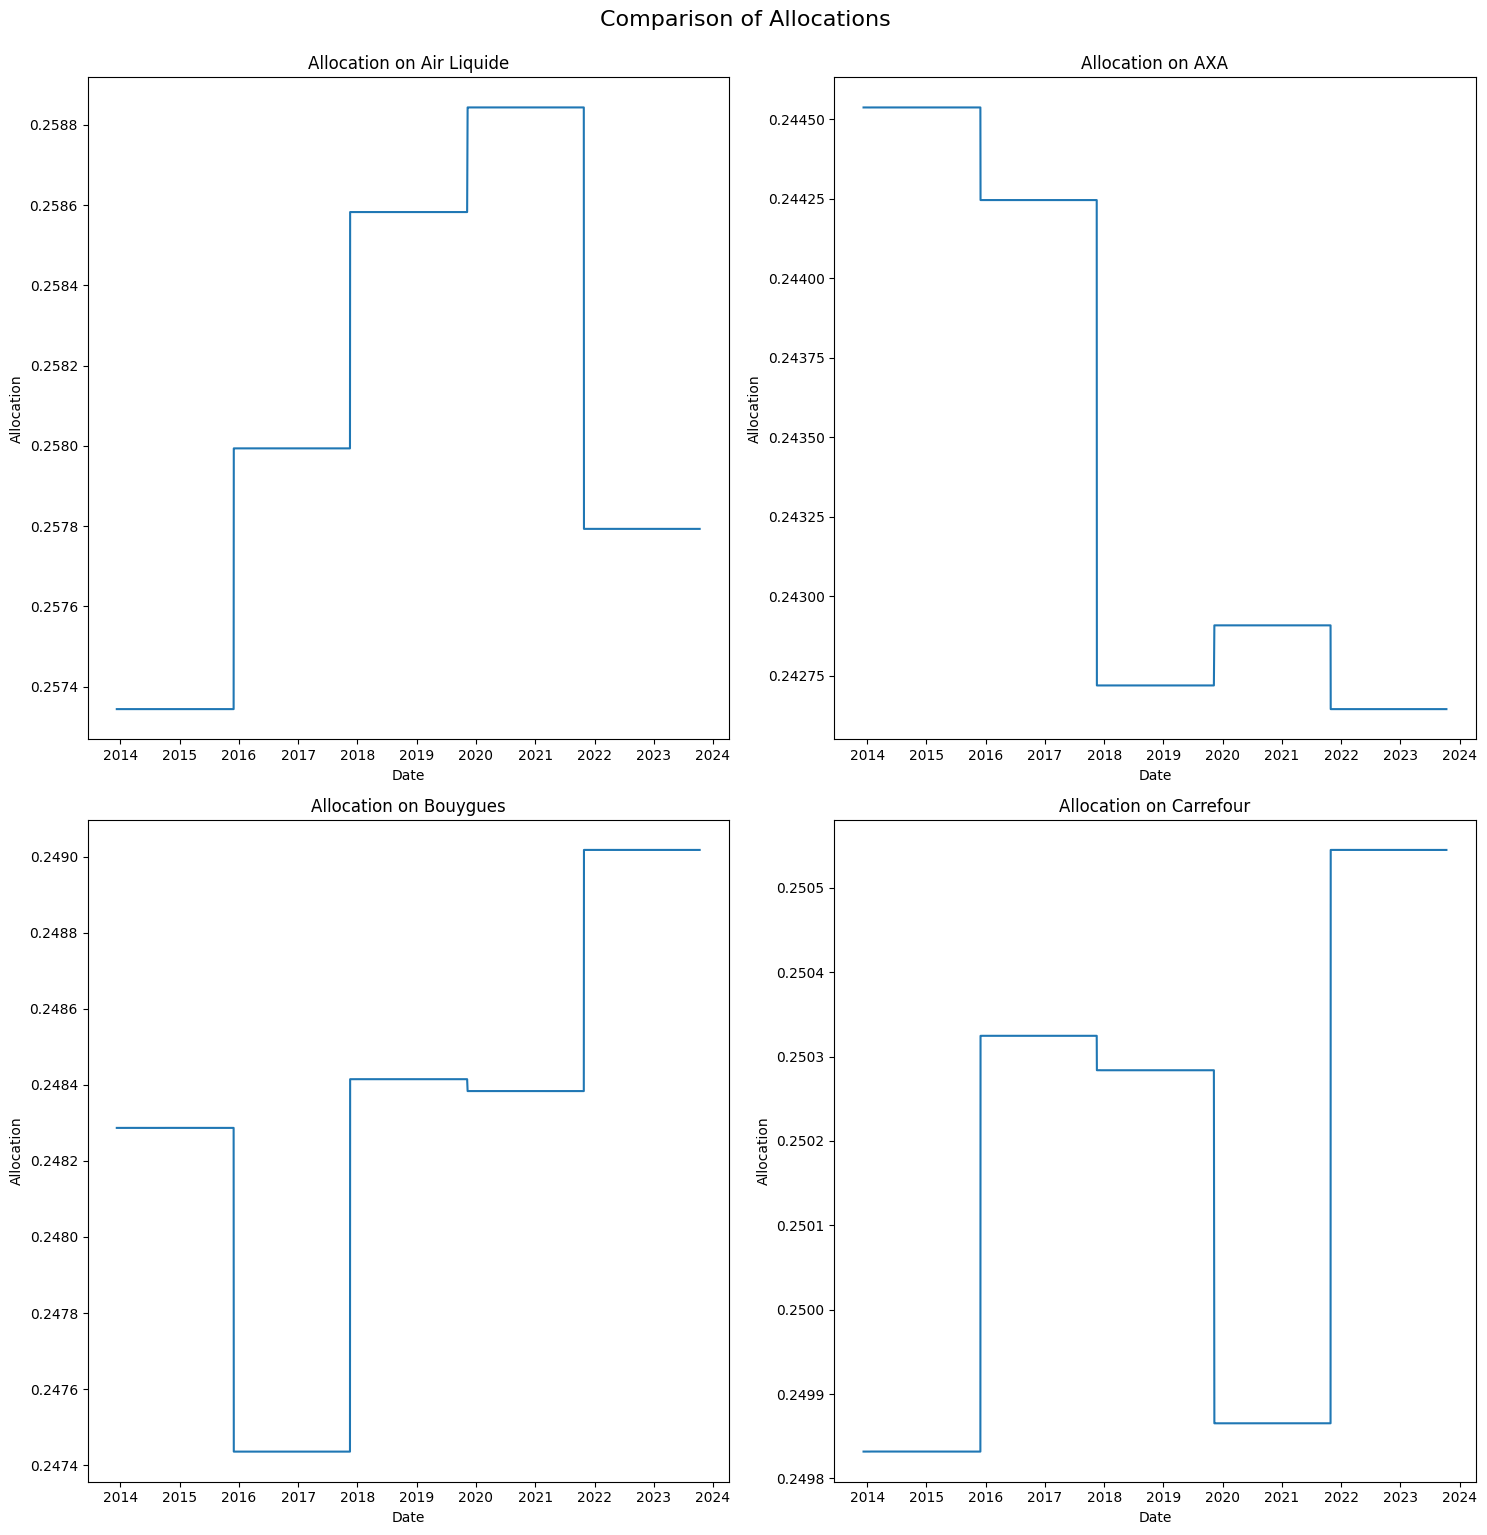

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axs = axs.flatten()

subplot_titles = [
    "Allocation on Air Liquide", "Allocation on AXA",
    "Allocation on Bouygues", "Allocation on Carrefour"
]

for i, ax in enumerate(axs):
    ax.set_title(subplot_titles[i])

# Allocation columns dictionary
allocations = {    
    'Air Liquide_alloc': 0,
    'AXA_alloc': 1,
    'Bouygues_alloc': 2,
    'Carrefour_alloc': 3
}

# Plot allocation for each asset
for alloc, ax_index in allocations.items():
    ax = axs[ax_index]
    if alloc in paper_results.columns:
        ax.plot(
            paper_results.index,
            paper_results[alloc],
            label=alloc,
        )
    ax.set_xlabel('Date')
    ax.set_ylabel('Allocation')

plt.tight_layout()
plt.suptitle("Comparison of Allocations", fontsize=16, y=1.02)
plt.show()

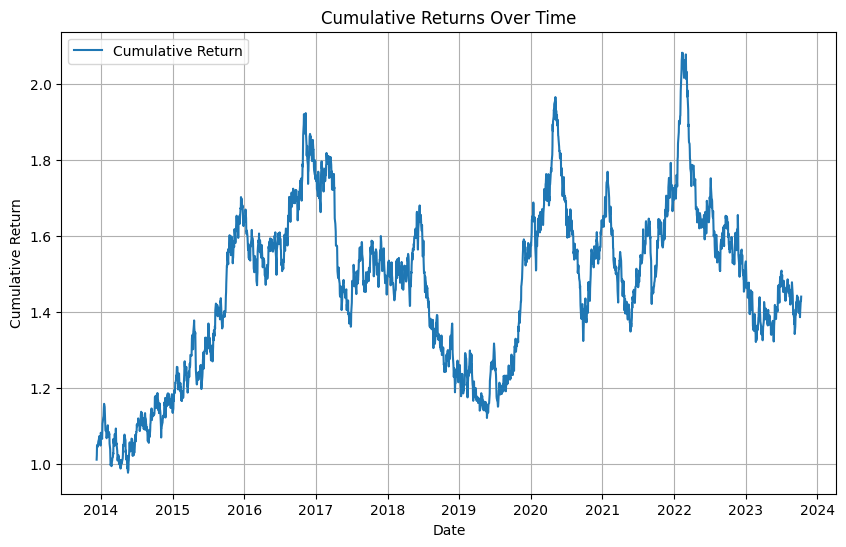

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(paper_results.index, paper_results['cumulative_return'], label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()


# LSTM with overlapping 

In [36]:
input_size=4
hidden_size=64  
output_size=4  
num_layers=1  
model_name='GRU'

model = NN_Sharpe(input_size, hidden_size, output_size, num_layers, model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.2)


In [37]:
num_simulations = simulated_returns.shape[1]  
dates = market_data.index[:simulated_returns.shape[0]]  

# Itérer sur chaque simulation
for i in range(num_simulations):
    # Extraire la simulation i
    single_simulation = simulated_returns[:, i, :]
    
    simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
    simulation_df.index = dates[:len(simulation_df)]  
    
    print(f"Training on simulation {i + 1}/{num_simulations}...")

    # Entraîner le modèle sur cette simulation
    simulation_result = training_with_model(
        data_used=simulation_df.dropna(),  
        model=model, 
        optimizer=optimizer, 
        initial_train_years=4,  
        retrain_years=2,  
        rolling_window=50, 
        shuffle=False,  
        epoch=50,
        batch_size=64,  
        overlap=False 
    )

    #taking the final results 
    if(i==num_simulations-1):
        results = simulation_result
    



Training on simulation 1/10...
training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([20, 50, 4])
epoch 0, loss = -0.05730580538511276
epoch 1, loss = -0.05731352046132088
epoch 2, loss = -0.05732092261314392
epoch 3, loss = -0.057327620685100555
epoch 4, loss = -0.057333819568157196
epoch 5, loss = -0.05733977630734444
epoch 6, loss = -0.057345617562532425
epoch 7, loss = -0.057351481169462204
epoch 8, loss = -0.057357460260391235
epoch 9, loss = -0.05736362934112549
epoch 10, loss = -0.05736996605992317
epoch 11, loss = -0.057376403361558914
epoch 12, loss = -0.05738287419080734
epoch 13, loss = -0.05738932639360428
epoch 14, loss = -0.057395659387111664
epoch 15, loss = -0.05740184709429741
epoch 16, loss = -0.057407863438129425
epoch 17, loss = -0.057413749396800995
epoch 18, loss = -0.05741953104734421
epoch 19, loss = -0.057425253093242645
epoch 20, loss = -0.05743097513914108
epoch 21, loss = -0.057436745613813

In [38]:
results = results.dropna(how='any')
results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.256875,0.245352,0.247430,0.250343,0.010389
2013-12-11,0.256875,0.245352,0.247430,0.250343,0.011430
2013-12-12,0.256875,0.245352,0.247430,0.250343,0.024886
2013-12-13,0.256875,0.245352,0.247430,0.250343,0.001912
2013-12-16,0.256875,0.245352,0.247430,0.250343,-0.004609
...,...,...,...,...,...
2023-10-05,0.257470,0.243142,0.248485,0.250903,-0.006433
2023-10-06,0.257470,0.243142,0.248485,0.250903,0.011556
2023-10-09,0.257470,0.243142,0.248485,0.250903,0.020608


In [39]:
paper_results = results.copy()

paper_results['cumulative_return'] = (1 + paper_results['return_pf']).cumprod()



In [40]:
paper_results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf,cumulative_return
Date,,,,,,
2013-12-10,0.256875,0.245352,0.247430,0.250343,0.010389,1.010389
2013-12-11,0.256875,0.245352,0.247430,0.250343,0.011430,1.021937
2013-12-12,0.256875,0.245352,0.247430,0.250343,0.024886,1.047370
2013-12-13,0.256875,0.245352,0.247430,0.250343,0.001912,1.049372
2013-12-16,0.256875,0.245352,0.247430,0.250343,-0.004609,1.044535
...,...,...,...,...,...,...
2023-10-05,0.257470,0.243142,0.248485,0.250903,-0.006433,1.384787
2023-10-06,0.257470,0.243142,0.248485,0.250903,0.011556,1.400790
2023-10-09,0.257470,0.243142,0.248485,0.250903,0.020608,1.429658


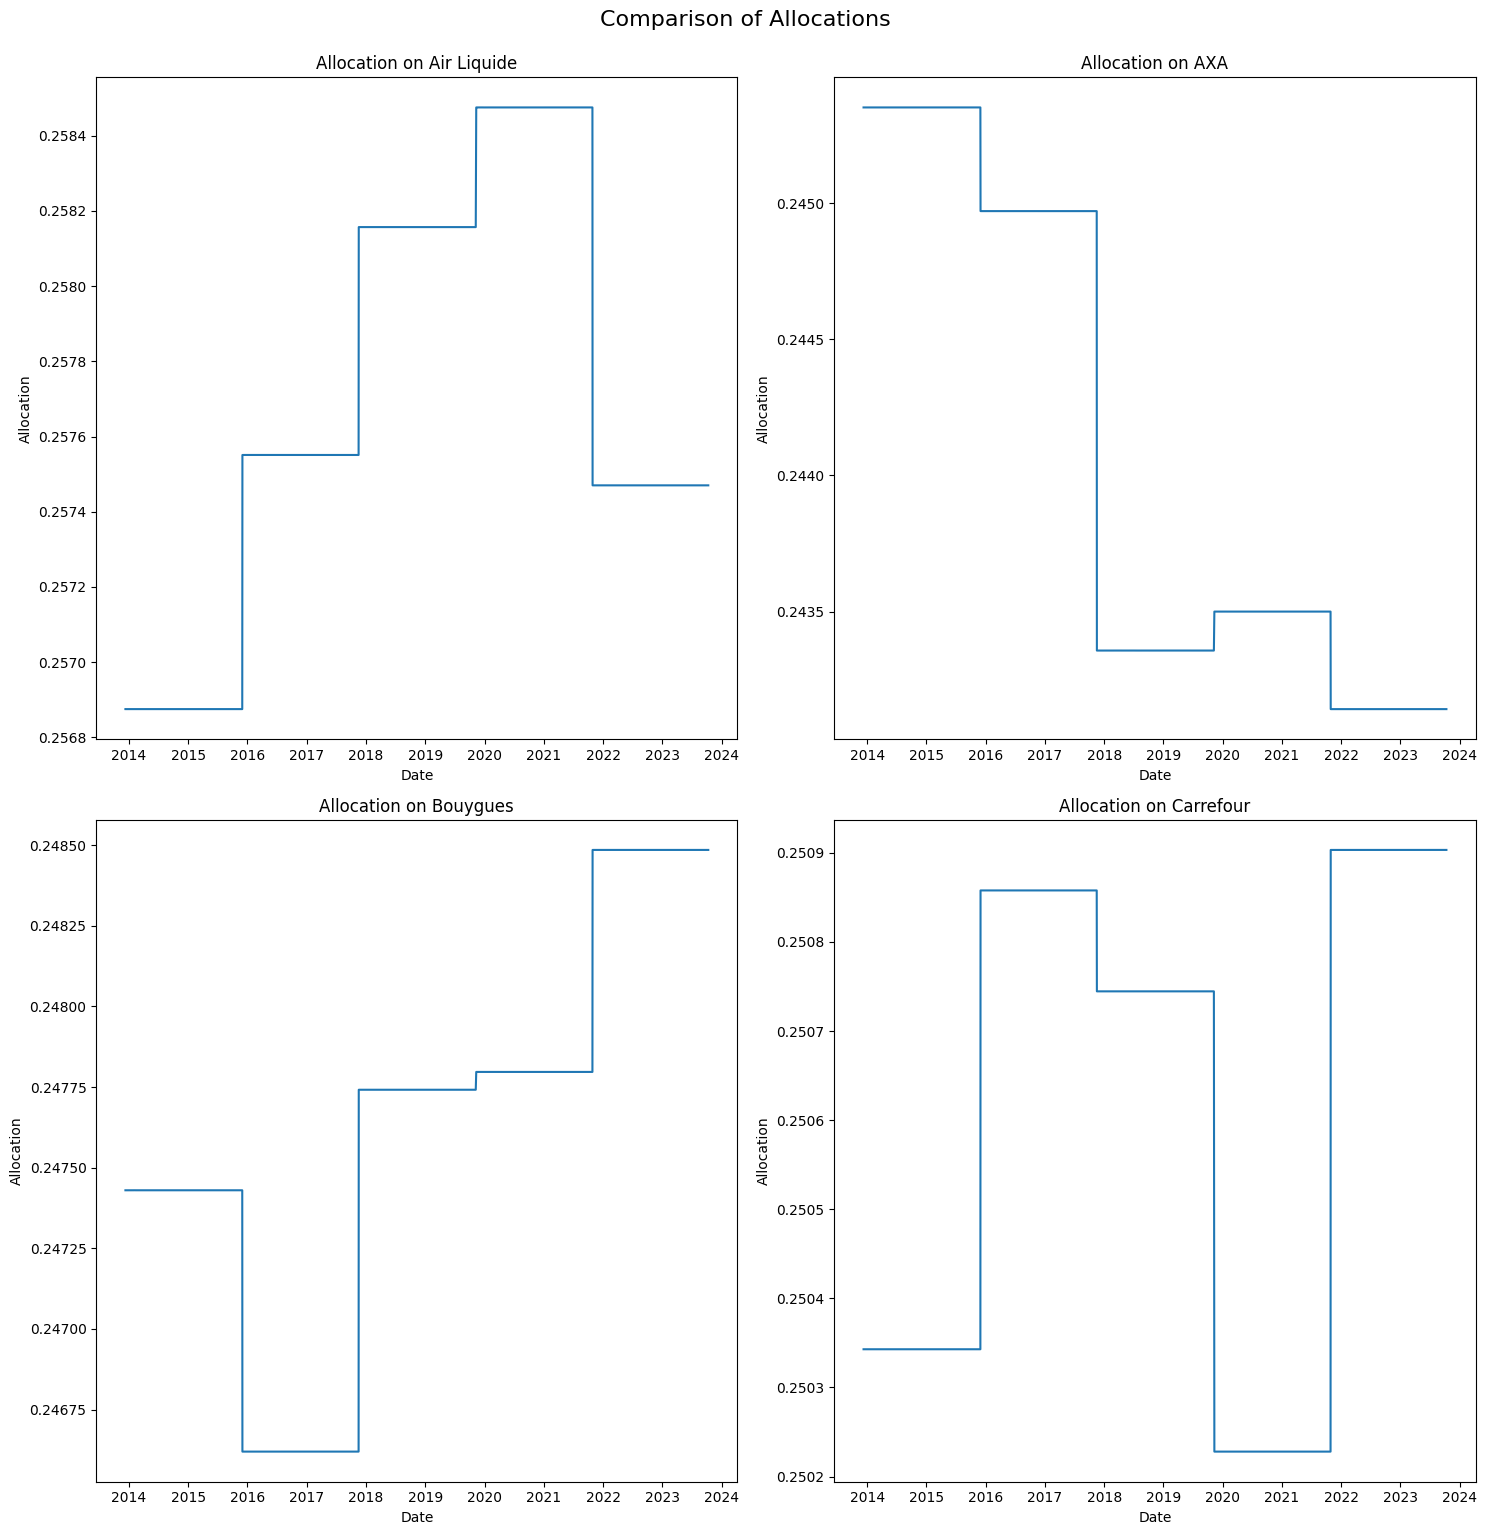

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axs = axs.flatten()

subplot_titles = [
    "Allocation on Air Liquide", "Allocation on AXA",
    "Allocation on Bouygues", "Allocation on Carrefour"
]

for i, ax in enumerate(axs):
    ax.set_title(subplot_titles[i])

# Allocation columns dictionary
allocations = {    
    'Air Liquide_alloc': 0,
    'AXA_alloc': 1,
    'Bouygues_alloc': 2,
    'Carrefour_alloc': 3
}

# Plot allocation for each asset
for alloc, ax_index in allocations.items():
    ax = axs[ax_index]
    if alloc in paper_results.columns:
        ax.plot(
            paper_results.index,
            paper_results[alloc],
            label=alloc,
        )
    ax.set_xlabel('Date')
    ax.set_ylabel('Allocation')

plt.tight_layout()
plt.suptitle("Comparison of Allocations", fontsize=16, y=1.02)
plt.show()

In [42]:
paper_results['cumulative_return']

Date
2013-12-10    1.010389
2013-12-11    1.021937
2013-12-12    1.047370
2013-12-13    1.049372
2013-12-16    1.044535
                ...   
2023-10-05    1.384787
2023-10-06    1.400790
2023-10-09    1.429658
2023-10-10    1.427245
2023-10-11    1.439028
Name: cumulative_return, Length: 2520, dtype: float64

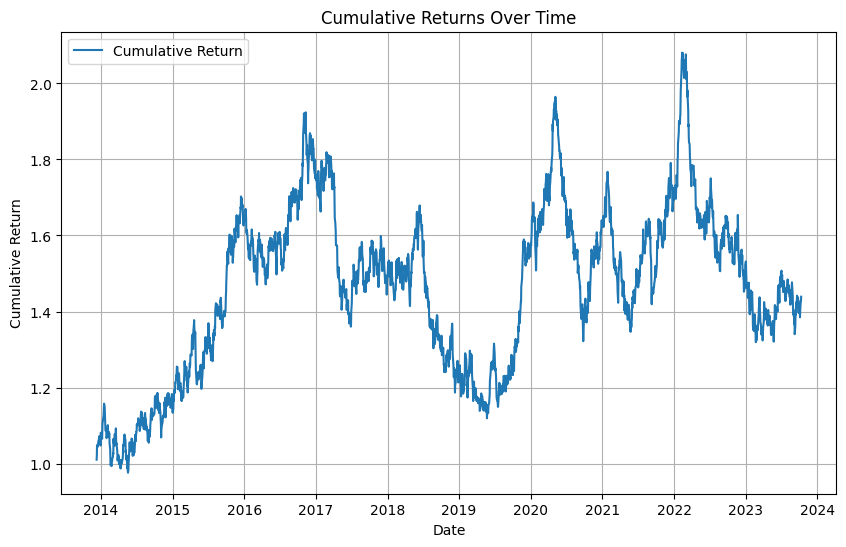

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(paper_results.index, paper_results['cumulative_return'], label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()
